# Hybrid vortex sheet-point vortex model

In [1]:
using PotentialFlow

In [2]:
using Plots
using ProgressMeter
using SpecialFunctions
using UnPack

### Time Marching

In [3]:
function compute_ẋ!(ẋ, x, t)
   plate, ambient_sys = x
    motion = ẋ[1]
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    Plates.enforce_no_flow_through!(plate, motion, ambient_sys, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

In [4]:
counter_min(Tmin,Δt) = isinf(Tmin) ? Inf : round(Int,Tmin/Δt)

counter_min (generic function with 1 method)

## Comparison with Theodorsen 

Set up the Theodorsen solution

In [5]:
C(κ::Float64) = hankelh2(1,κ)/(hankelh2(1,κ)+im*hankelh2(0,κ))

struct Theodorsen
    kin :: RigidBodyMotions.PitchHeave
    L   :: Float64
end

function (theo::Theodorsen)(t::Float64)
    @unpack L, kin = theo
    @unpack Y,Ẏ,U₀,α,a,α̇,Ÿ,α̈,K = kin
    # defined for motion in +x direction
    ReΓb = π*L*(-Ẏ(t) + U₀*α(t) + (1/4 + a)*L*α̇(t))
    ImΓb = π*L*(-2K*Y(t) - U₀*α̇(t)/(2K) + (1/4 + a)*L*2K*α(t))
    fy = π*(L/2)^2*(-Ÿ(t) + a*α̈(t) + U₀*α̇(t)) + U₀*real((ReΓb+im*ImΓb)*C(K))
    momp = π*(L/2)^2*(a*Ÿ(t)-(L^2/32+a^2)*α̈(t)-(L/4+a)*U₀*α̇(t)) + (L/4-a)*U₀*real((ReΓb+im*ImΓb)*C(K))
    return fy, momp+a*fy
end

Now set up the problem parameters and kinematic

In [6]:
L = 1.0   # chord length

a = 0.5 #0.25 # location of pitch axis, a = 0.5 is leading edge
ϕ = -π/2  # phase lag of pitch to heave
A = 0.0 #0.0  # amplitude/chord
fstar = 1/π # fc/U
α₀ = 0 # mean angle of attack
Δα = 5π/180 #2π/180 # amplitude of pitching


#=
# Kinsey-Dumas case
a = 0.2 #0.2 # location of pitch axis, a = 0.5 is leading edge
ϕ = -π/2  # phase lag of pitch to heave
A = 1.0 #1.0  # amplitude/chord
fstar = 0.14 # fc/U
α₀ = 0π/180 # mean angle of attack
Δα = 60π/180 #20π/180 # amplitude of pitching
=#

χ = Δα/atan(2π*A*fstar)
K = π*fstar # reduced frequency, K = πfc/U
println("f* = ",fstar)
println("Δα = ",Δα*180/π)
println("α(1/4) = ",abs(atan(2*K*A)-Δα)*180/π)
println("A/c = ",A)
println("K = ",K)
println("χ = ",χ)

oscil = RigidBodyMotions.PitchHeave(1.0,a,K,ϕ,α₀,Δα,A);
motion = Plates.RigidBodyMotion(oscil);

f* = 0.3183098861837907
Δα = 5.0
α(1/4) = 5.0
A/c = 0.0
K = 1.0
χ = Inf


### Plot the effective angle of attack

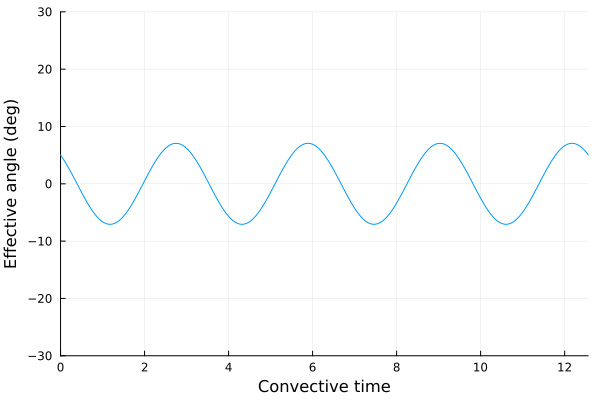

In [10]:
t = 0:0.01:(4.0./fstar)
Vy = map(x -> imag(x[1]),motion.kin.(t))
αeff = atan.(-Vy)+motion.kin.α.(t)
plot(t,αeff*180/π,xlim=(0,Inf),ylim=(-30,30),legend=false,ylabel="Effective angle (deg)",xlabel="Convective time")

### Select the metaparameters for the hybrid vortex model

* $N$ is the number of plate control points

* $\Delta t$ is the time step size.

* $\delta$ is the blob radius. It is best to set this to around 0.05 times the chord length.

* `lesp` and `tesp` are the critical edge suction parameters at the leading and trailing edge, respectively
    - Setting this to 0 leads to the Kutta condition at that edge
    -  Setting this to a large positive value ($\sim 10$) suppresses vortex shedding from that edge

* $B_f$ sets the tolerance for force error in the hybrid model.
    - Setting this to zero turns off variable-strength point vortices and generates a traditional vortex model. 
    - It is generally advisable to set this to around 0.05 or 0.1 

* $T^*_{min}$ sets the minimum time interval between the release of a new active vortex from the tip of each vortex sheet.
    - Setting this to infinity (and setting $B_f$ to 0) generates a pure vortex sheet model.
    - Setting this to 0 generates a discrete vortex model
    - For a hybrid model, it is generally best to set this between 0.1 and 0.3
    
* $t_f$ is the final time    

In [44]:
N = 128 

Δt = 1e-2
δ = 0.05 #0.1 #0.01

lesp = 10 #0.1
tesp = 0.0

Bf = 1.75e-2 #1e-1
Tmin = [Inf,4e-1]; #2e-1];

tf = 10

10

Run it!

In [45]:
plate = Plate(N, L, 0, motion.kin.α(0.0))

Plates.enforce_no_flow_through!(plate, motion, (), 0.0)

sys = (plate, ((), ()))

# sys[1] is the plate, sys[2] is the vortex system
# sys[2][i] corresponds to edge i (i = 1 is leading edge, i = 2 is trailing edge)
# sys[2][i][1] is the set of blobs associated with edge i
# sys[2][i][1][1] is the current active vortex for edge i
# sys[2][i][2] is the vortex sheet associated with edge i. Its first entry will be turned into a blob.

sys = PotentialFlow.shed_new_vorticity!(sys, motion, δ, 0.0, lesp, tesp)

states = Tuple[];
forces = [];
moments = [];

T = Δt:Δt:tf

# Set up Theodorsen solution results
theo = Theodorsen(oscil,L)
fytheo = map(x -> x[1], theo.(Δt:Δt:tf))
momtheo = map(x -> x[2], theo.(Δt:Δt:tf))

counter = [0, 0]

countermin = counter_min.(Tmin,Δt)
ϵf = Bf*Δt 

@showprogress for t in T
    push!(states, deepcopy(sys))
   
    ẋs = (motion, allocate_velocity(sys[2]))

    compute_ẋ!(ẋs, sys, t)
    
    lesys, tesys = sys[2]
    push!(forces, Plates.force(plate, motion, sys[2], ẋs[2], (newest_element(lesys...)..., newest_element(tesys...)...), Δt))   
    push!(moments, Plates.moment(plate, motion, sys[2], ẋs[2], (newest_element(lesys...)..., newest_element(tesys...)...), Δt))   

    advect!(sys, sys, ẋs, Δt)
    
    for i in 1:2  # each edge
        
        # If this edge's vortex system is not set up, then skip the transfer
        length(sys[2][i]) == 2 || continue
        
        edge_blobs, edge_sheet = sys[2][i]
        
        # Calculate the impulse matching corrections to the active vortex position
        Δzs = [impulse_matching_correction(sblob, edge_blobs[1], plate) for sblob in edge_sheet.blobs]    
      
        # Circulation is only transferred from the sheet to the active blob if
        # - the sheet is long enough, and
        # - more than one sheet segment can be transferred without surpassing the error tolerance
        new_blob = transfer_circulation!(edge_sheet, edge_blobs[1], Δzs, plate, ϵf)

        # If the active blob has been modified, then set the counter to zero. Otherwise, increment
        # the counter.
        if new_blob == edge_blobs[1]
            counter[i] += 1
        else
            counter[i] = 0
            edge_blobs[1] = new_blob
        end
        
        # if we have waited long enough between active blob releases, and the sheet is sufficiently long,
        # then convert current active vortex into an inactive one, and release tip of sheet as new active vortex
        if length(edge_sheet) > 2 && counter[i] > countermin[i]
            sheettip_to_blob!(edge_blobs,edge_sheet)
            counter[i] = 0
        end
    end
    
    # Fix up the vortex sheet with filtering or remeshing
    for i in 1:2
        length(sys[2][i]) == 2 || continue
        edge_blobs, edge_sheet = sys[2][i]
        
        # Filter
        Sheets.arclength(edge_sheet) ≥ 50Δt && Sheets.filter!(edge_sheet, 2Δt, 8Δt)
        
        # or remesh
        #Sheets.arclength(edge_sheet) ≥ 30Δt && Sheets.remesh!(edge_sheet,2Δt)
    end
      
    Plates.enforce_no_flow_through!(plate, motion, sys[2], t)
    sys = shed_new_vorticity!(sys, motion, δ, t, lesp, tesp)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


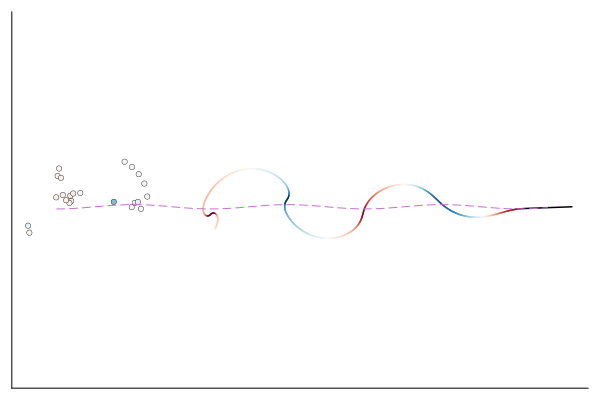

In [46]:
plt = plot(states[end],color = cgrad(:RdBu,rev=true), ratio=1,legend=:none,markersize=3,markerstrokealpha=1,
            markerstrokewidth=0.5,linewidth=1.5,ticks=nothing,border=nothing,framestyle=false,
            clim=(-0.5,0.5)) #,ylim=(-3,3))

# Plot the trajectory
zc = map(x -> x[1].c,states[1:end]) 
plot!(real.(zc),imag.(zc),linestyle=:dash)
plt

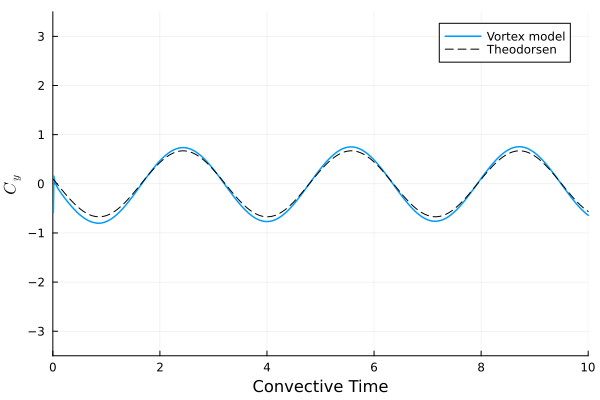

In [47]:
plt = plot(ylabel = "\$C_y\$", xlim = (0,Inf), ylim = (-3.5,3.5), 
    xlabel = "Convective Time")
plot!(Δt:Δt:tf, 2imag.(forces), linewidth = 1.5, linestyle = :solid, label = "Vortex model")
plot!(Δt:Δt:tf, 2fytheo, linewidth = 1, linestyle = :dash, color = :black, label = "Theodorsen")
plt

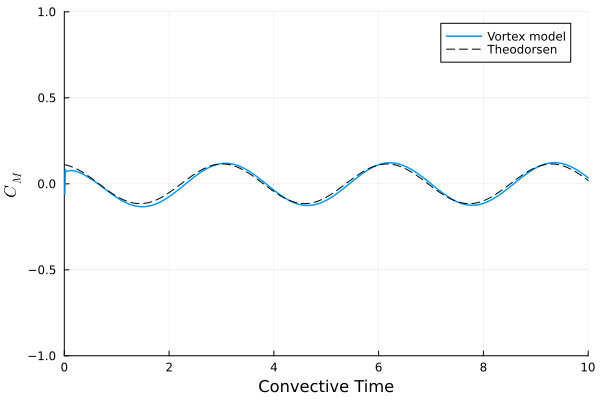

In [33]:
plt = plot(ylabel = "\$C_M\$", xlim = (0,Inf), ylim = (-1,1), 
    xlabel = "Convective Time")
plot!(plt,Δt:Δt:tf, 2moments, linewidth = 1.5, linestyle = :solid, label = "Vortex model")
plot!(plt,Δt:Δt:tf, 2momtheo, linewidth = 1, linestyle = :dash, color = :black, label = "Theodorsen")